In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Library Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import os
import warnings
import soundfile
import pickle
warnings.filterwarnings('ignore')
from IPython.display import Audio

In [3]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report,f1_score,recall_score

#Creating DataFrame

##Labeling Dataframe

In [12]:
main_folder = os.path.join('/content', 'drive', 'MyDrive', 'Infant_cry_classification', 'donateacry_corpus')
models_folder = os.path.join('/content', 'drive', 'MyDrive', 'Infant_cry_classification', 'Models')

# List to store file paths and labels
file_paths = []
labels = []

# Iterate over subfolders
for folder_name in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder_name)
    if os.path.isdir(folder_path):
        # Iterate over files in subfolder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                file_paths.append(os.path.join(folder_path, file_name))
                labels.append(folder_name.capitalize())


##2D DataFrame

In [13]:
df = pd.DataFrame({'Path': file_paths, 'Condition': labels})
print(df.head())

                                                Path   Condition
0  /content/drive/MyDrive/Infant_cry_classificati...  Belly_pain
1  /content/drive/MyDrive/Infant_cry_classificati...  Belly_pain
2  /content/drive/MyDrive/Infant_cry_classificati...  Belly_pain
3  /content/drive/MyDrive/Infant_cry_classificati...  Belly_pain
4  /content/drive/MyDrive/Infant_cry_classificati...  Belly_pain


##Countplot of Dataset

In [14]:
condition_counts = df['Condition'].value_counts()
print(condition_counts)

Condition
Discomfort    459
Belly_pain    448
Hungry        434
Tired         432
Burping       424
Name: count, dtype: int64


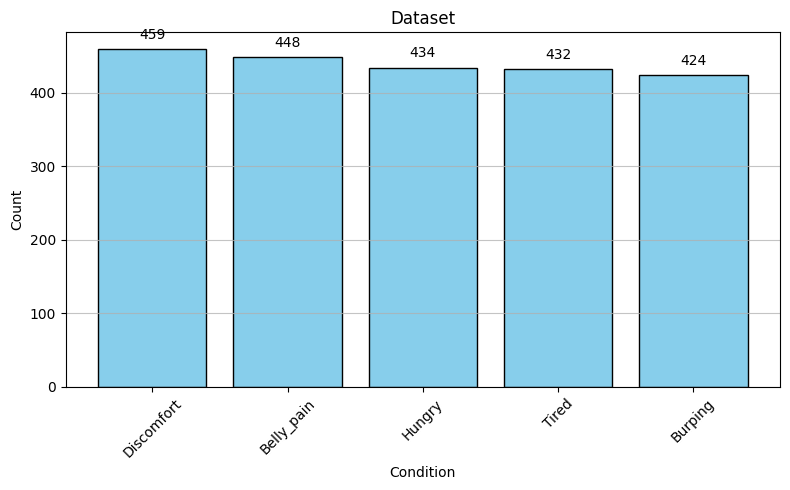

In [15]:
import matplotlib.pyplot as plt

condition_counts = df['Condition'].value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(condition_counts.index, condition_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Dataset')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)

# Adding count labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()

#Data Pre-Processing

##Feature Extraction

In [16]:
def extract_features(filename):
    with soundfile.SoundFile(filename) as soundFile:
        x = soundFile.read(dtype="float32")
        sampleRate = soundFile.samplerate
        all = np.array([])

        # MFCC -> 40 features
        mfccs = np.mean(librosa.feature.mfcc(y=x, sr=sampleRate, n_mfcc=40).T, axis=0)
        all = np.hstack((all, mfccs))

        # Mel Spectrogram -> 128 features
        melSpec = np.mean(librosa.feature.melspectrogram(y=x, sr=sampleRate).T, axis=0)
        all = np.hstack((all, melSpec))

        # Spectral contrast -> 7 features
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=x, sr=sampleRate, fmin=20, n_bands=7).T, axis=0)
        all = np.hstack((all, spectral_contrast))

        # Chroma -> 12 features
        chroma = np.mean(librosa.feature.chroma_stft(y=x, sr=sampleRate, n_chroma=12).T, axis=0)
        all = np.hstack((all, chroma))

        # Tonnetz -> 6 features
        tonnetz = np.mean(librosa.feature.tonnetz(y=x, sr=sampleRate * 2, n_chroma=6).T, axis=0)
        all = np.hstack((all, tonnetz))

    return all

##Splitting The Data (Test and Train)

In [ ]:
x, y = [],[]
for ind in df.index:
    condition = df['Condition'][ind]
    file = df['Path'][ind]

    all_features = extract_features(file)

    x.append(all_features)
    y.append(condition)

    features = pd.DataFrame({'Features': x,'Conditon': y})

In [21]:
np.array(x).shape

(1647, 194)

In [ ]:
x_, xTest, y_, yTest = train_test_split(np.array(x), y, test_size=0.25, random_state=42)

In [ ]:
xTrain,xVal,yTrain,yVal = train_test_split(x_,y_,test_size = 0.15,random_state = 42)

In [22]:
xTrain.shape,xTest.shape,xVal.shape

((1399, 194), (550, 194), (248, 194))

##Loading the test train validation array

In [20]:
x = pd.read_csv(os.path.join(main_folder, 'x.csv')).values
y = pd.read_csv(os.path.join(main_folder, 'y.csv')).values

xTrain = pd.read_csv(os.path.join(main_folder, 'xTrain.csv')).values
yTrain = pd.read_csv(os.path.join(main_folder, 'yTrain.csv')).values

xTest = pd.read_csv(os.path.join(main_folder, 'xTest.csv')).values
yTest = pd.read_csv(os.path.join(main_folder, 'yTest.csv')).values

xVal = pd.read_csv(os.path.join(main_folder, 'xVal.csv')).values
yVal = pd.read_csv(os.path.join(main_folder, 'yVal.csv')).values

In [23]:
observedCondition = ['hungry', 'burping', 'belly_pain', 'discomfort', 'tired']

In [24]:
print((x_.shape[0],xTrain.shape[0], xTest.shape[0],xVal.shape[0]))
print('Features extracted: ',xTest.shape[1])

(1647, 1399, 550, 248)
Features extracted:  194


#KNN

###HyperParametre tuning of KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

# Create a KNN classifier
knn = KNeighborsClassifier()

# Define the grid of parameters to search
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(xTrain, yTrain)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


##KNN Models

In [25]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3,metric='manhattan',weights='distance')

In [27]:
knn.fit(xTrain,yTrain)

y_predict_train = knn.predict(xTrain)
train_accuracy_knn = accuracy_score(y_predict_train,yTrain)

y_predict_test = knn.predict(xTest)
test_accuracy_knn = accuracy_score(y_predict_test,yTest)

with open(os.path.join(models_folder, 'knn_model.pkl'), 'wb') as file:
    pickle.dump(knn, file)

##KNN Accuracy

In [28]:
print('Overall Model Performance:')
print(f'- Training Accuracy: {train_accuracy_knn*100:.2f}%')
print(f'- Testing Accuracy: {test_accuracy_knn*100:.2f}%\n')

Overall Model Performance:
- Training Accuracy: 100.00%
- Testing Accuracy: 94.55%



##KNN Results

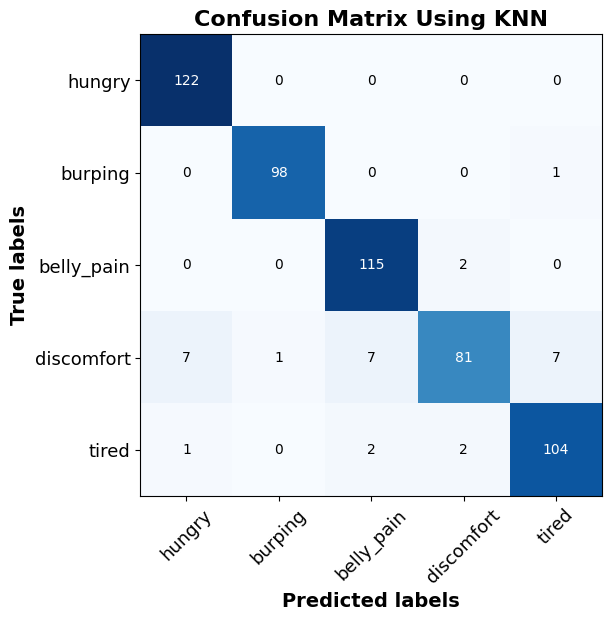

In [29]:
knn.fit(xTrain,yTrain)
yExpect = yTest
yPred = knn.predict(xTest)

conf_matrix = confusion_matrix(yExpect, yPred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Blues)

ax.set_xlabel('Predicted labels', fontsize=14, weight = 'bold')
ax.set_ylabel('True labels', fontsize=14, weight = 'bold')
ax.set_title('Confusion Matrix Using KNN', fontsize=16, weight = 'bold')
ax.xaxis.set_ticklabels([''] + observedCondition, fontsize=13, rotation=45)
ax.yaxis.set_ticklabels([''] + observedCondition, fontsize=13)
plt.show()

In [30]:
from sklearn.metrics import f1_score,recall_score,precision_score,classification_report
yExpect = yTest
yPred = knn.predict(xTest)

f1 = f1_score(yExpect, yPred, average='weighted') * 100
recall = recall_score(yExpect, yPred, average='weighted') * 100
precision = precision_score(yExpect, yPred, average='weighted') * 100

print(f'F-1 Score: {f1:.4f}')
print(f'Recall Score: {recall:.4f}')
print(f'Precision Score: {precision:.4f}')
print('Classification Report:\n', classification_report(yExpect, yPred))

F-1 Score: 94.3873
Recall Score: 94.5455
Precision Score: 94.6123
Classification Report:
               precision    recall  f1-score   support

  Belly_pain       0.94      1.00      0.97       122
     Burping       0.99      0.99      0.99        99
  Discomfort       0.93      0.98      0.95       117
      Hungry       0.95      0.79      0.86       103
       Tired       0.93      0.95      0.94       109

    accuracy                           0.95       550
   macro avg       0.95      0.94      0.94       550
weighted avg       0.95      0.95      0.94       550



#Random Forrest

###HyperParametre Tunning of RF

In [ ]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import make_scorer, f1_score

rf = RandomForestClassifier()

# Define hyperparameters
param_dist = {
    'n_estimators': randint(10, 1000),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': randint(1, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
}

scoring = {'f1_micro': make_scorer(f1_score, average='micro'),
           'f1_macro': make_scorer(f1_score, average='macro')}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, scoring=scoring, refit='f1_micro', cv=5, random_state=42)
random_search.fit(xVal, yVal)

print("Best Parameters: ", random_search.best_params_)
print("Best F1 Micro Score: ", random_search.best_score_)
print("Best F1 Macro Score: ", random_search.cv_results_['mean_test_f1_macro'][random_search.best_index_])

Best Parameters:  {'max_depth': 33, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 137}
Best F1 Micro Score:  0.8787755102040815
Best F1 Macro Score:  0.8770230828692801


##Random Forrest Models

In [31]:
from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=137, max_depth=33, max_features='log2', min_samples_leaf=1, min_samples_split=4)

In [32]:
rf.fit(xTrain, yTrain)

y_rf_predict_train = rf.predict(xTrain)
train_accuracy_rf = accuracy_score(y_rf_predict_train, yTrain)

y_rf_predict_test = rf.predict(xTest)
test_accuracy_rf = accuracy_score(y_rf_predict_test, yTest)

with open(os.path.join(models_folder, 'rf_model.pkl'), 'wb') as file:
    pickle.dump(rf, file)

##RF Accuracy

In [33]:
print('Overall Model Performance:')
print(f'- Training Accuracy: {train_accuracy_rf*100:.2f}%')
print(f'- Testing Accuracy: {test_accuracy_rf*100:.2f}%\n')

Overall Model Performance:
- Training Accuracy: 100.00%
- Testing Accuracy: 97.82%



##RF Results

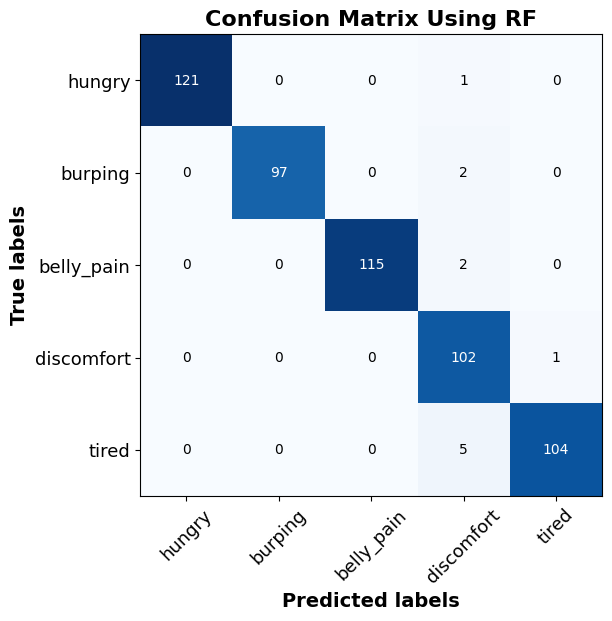

In [34]:
rf.fit(xTrain, yTrain)
yExpect = yTest
yPred = rf.predict(xTest)

conf_matrix = confusion_matrix(yExpect, yPred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Blues)

ax.set_xlabel('Predicted labels', fontsize=14, weight = 'bold')
ax.set_ylabel('True labels', fontsize=14, weight = 'bold')
ax.set_title('Confusion Matrix Using RF', fontsize=16, weight = 'bold')
ax.xaxis.set_ticklabels([''] + observedCondition, fontsize=13, rotation=45)
ax.yaxis.set_ticklabels([''] + observedCondition, fontsize=13)
plt.show()

In [35]:
from sklearn.metrics import f1_score,recall_score,precision_score,classification_report
yExpect = yTest
yPred = rf.predict(xTest)

f1 = f1_score(yExpect, yPred, average='weighted') * 100
recall = recall_score(yExpect, yPred, average='weighted') * 100
precision = precision_score(yExpect, yPred, average='weighted') * 100

print(f'F-1 Score: {f1:.4f}')
print(f'Recall Score: {recall:.4f}')
print(f'Precision Score: {precision:.4f}')
print('Classification Report:\n', classification_report(yExpect, yPred))

F-1 Score: 98.0279
Recall Score: 98.0000
Precision Score: 98.1392
Classification Report:
               precision    recall  f1-score   support

  Belly_pain       1.00      0.99      1.00       122
     Burping       1.00      0.98      0.99        99
  Discomfort       1.00      0.98      0.99       117
      Hungry       0.91      0.99      0.95       103
       Tired       0.99      0.95      0.97       109

    accuracy                           0.98       550
   macro avg       0.98      0.98      0.98       550
weighted avg       0.98      0.98      0.98       550



#SVM

###HyperParameter Tuning on SVM

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import randint
import numpy as np

# Define the SVM model
svm = SVC()

# Define the parameter grid-+
param_dist = {
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': randint(1, 10)
}

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=30, cv=5 , random_state=42)
random_search.fit(xVal,yVal)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)

Best Parameters: {'C': 0.001, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}


##SVM Models

In [36]:
from sklearn import svm
import pickle
svm_model = svm.SVC(C=0.01, degree=3, gamma=1.0, kernel='poly')

In [37]:
svm_model.fit(xTrain,yTrain)

y_svm_predict_train = svm_model.predict(xTrain)
train_accuracy_svm = accuracy_score(y_svm_predict_train, yTrain)

y_svm_predict_test = svm_model.predict(xTest)
test_accuracy_svm = accuracy_score(y_svm_predict_test, yTest)

with open(os.path.join(models_folder, 'svm_model.pkl'), 'wb') as file:
    pickle.dump(svm_model, file)

##SVM Accuracy

In [38]:
print('\nOverall Model Performance for SVM:')
print(f'- Training Accuracy: {train_accuracy_svm * 100:.2f}%')
print(f'- Testing Accuracy: {test_accuracy_svm * 100:.2f}%\n')


Overall Model Performance for SVM:
- Training Accuracy: 100.00%
- Testing Accuracy: 95.64%



##SVM Results

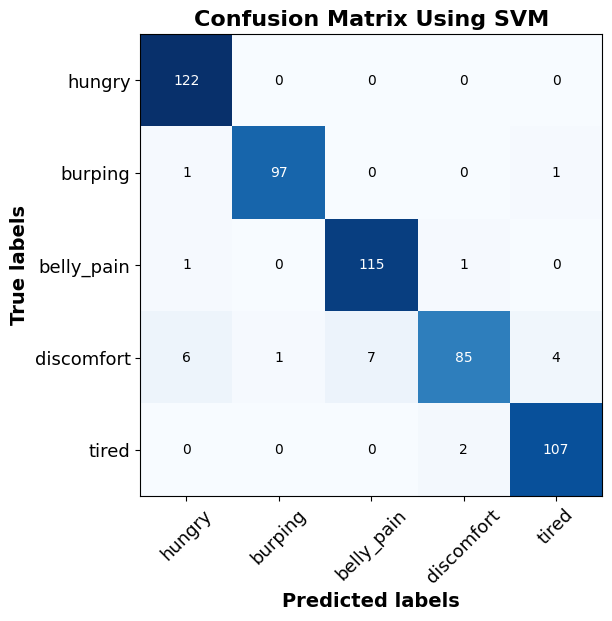

In [39]:
svm_model.fit(xTrain,yTrain)
yExpect = yTest
yPred = svm_model.predict(xTest)

conf_matrix = confusion_matrix(yExpect, yPred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Blues)

ax.set_xlabel('Predicted labels', fontsize=14, weight = 'bold')
ax.set_ylabel('True labels', fontsize=14, weight = 'bold')
ax.set_title('Confusion Matrix Using SVM', fontsize=16, weight = 'bold')
ax.xaxis.set_ticklabels([''] + observedCondition, fontsize=13, rotation=45)
ax.yaxis.set_ticklabels([''] + observedCondition, fontsize=13)
plt.show()

In [40]:
from sklearn.metrics import f1_score,recall_score,precision_score,classification_report
yExpect = yTest
yPred = svm_model.predict(xTest)

f1 = f1_score(yExpect, yPred, average='weighted') * 100
recall = recall_score(yExpect, yPred, average='weighted') * 100
precision = precision_score(yExpect, yPred, average='weighted') * 100

print(f'F-1 Score: {f1:.4f}')
print(f'Recall Score: {recall:.4f}')
print(f'Precision Score: {precision:.4f}')
print('Classification Report:\n', classification_report(yExpect, yPred))

F-1 Score: 95.5339
Recall Score: 95.6364
Precision Score: 95.7076
Classification Report:
               precision    recall  f1-score   support

  Belly_pain       0.94      1.00      0.97       122
     Burping       0.99      0.98      0.98        99
  Discomfort       0.94      0.98      0.96       117
      Hungry       0.97      0.83      0.89       103
       Tired       0.96      0.98      0.97       109

    accuracy                           0.96       550
   macro avg       0.96      0.95      0.95       550
weighted avg       0.96      0.96      0.96       550



#XGBoost


##HyperParametre Tuning on XG-Boost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.preprocessing import LabelEncoder

# Define the parameter grid for random search
param_dist = {
    'objective': ['multi:softmax'],
    'num_class': [5],
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(50, 200),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0, 0.5)
}

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(yVal)

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1)
random_search.fit(xVal, y_encoded)

# Print the best parameters found
print("Best parameters:", random_search.best_params_)

##XG-Boost Models

In [41]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

best_param = {'colsample_bytree': 0.7699205456508366,
                  'gamma': 0.1015306123673847,
                  'learning_rate': 0.1042853570557981,
                  'max_depth': 7,
                  'n_estimators': 135,
                  'num_class': 5,
                  'objective': 'multi:softmax',
                  'reg_alpha': 0.44023391950762886,
                  'reg_lambda': 0.3121770240668966,
                  'subsample': 0.647816842918857}

xg = xgb.XGBClassifier(objective="multi:softmax",param_distributions=best_param)

In [42]:
y_encoded = encoder.fit_transform(yTrain)
xg.fit(xTrain,y_encoded)

xg_predict_train = xg.predict(xTrain)
xg_accuracy_train = accuracy_score(xg_predict_train,y_encoded)

y_encoded = encoder.transform(yTest)

xg_predict_test = xg.predict(xTest)
xg_accuracy_test = accuracy_score(xg_predict_test, y_encoded)

with open(os.path.join(models_folder, 'xg_model.pkl'), 'wb') as file:
    pickle.dump(xg, file)

##XG-Boost Accuracy

In [43]:
print('\nOverall Model Performance for XGBoost:')
print(f'- Training Accuracy: {xg_accuracy_train * 100:.2f}%')
print(f'- Testing Accuracy: {xg_accuracy_test * 100:.2f}%\n')


Overall Model Performance for XGBoost:
- Training Accuracy: 100.00%
- Testing Accuracy: 97.27%



##XGBoost Results

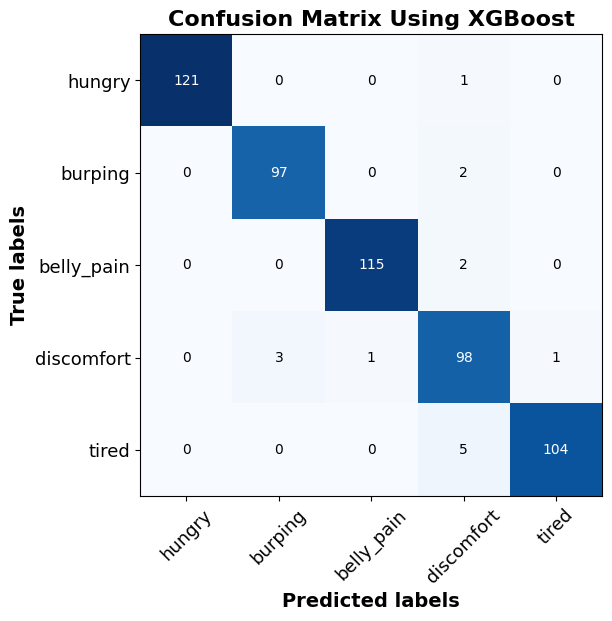

In [44]:
yExpect = encoder.fit_transform(yTest)
yPred = xg_predict_test

conf_matrix = confusion_matrix(yExpect, yPred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Blues)

ax.set_xlabel('Predicted labels', fontsize=14, weight = 'bold')
ax.set_ylabel('True labels', fontsize=14, weight = 'bold')
ax.set_title('Confusion Matrix Using XGBoost', fontsize=16, weight = 'bold')
ax.xaxis.set_ticklabels([''] + observedCondition, fontsize=13, rotation=45)
ax.yaxis.set_ticklabels([''] + observedCondition, fontsize=13)
plt.show()

In [45]:
from sklearn.metrics import f1_score,recall_score,precision_score,classification_report
yExpect = encoder.fit_transform(yTest)
yPred = xg_predict_test

f1 = f1_score(yExpect, yPred, average='weighted') * 100
recall = recall_score(yExpect, yPred, average='weighted') * 100
precision = precision_score(yExpect, yPred, average='weighted') * 100

print(f'F-1 Score: {f1:.4f}')
print(f'Recall Score: {recall:.4f}')
print(f'Precision Score: {precision:.4f}')
print('Classification Report:\n', classification_report(yExpect, yPred))

F-1 Score: 97.2956
Recall Score: 97.2727
Precision Score: 97.3539
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       122
           1       0.97      0.98      0.97        99
           2       0.99      0.98      0.99       117
           3       0.91      0.95      0.93       103
           4       0.99      0.95      0.97       109

    accuracy                           0.97       550
   macro avg       0.97      0.97      0.97       550
weighted avg       0.97      0.97      0.97       550



#Final Result and Conclusion

In [ ]:
!pip install tabulate

In [46]:
from tabulate import tabulate

# Example data (replace with your actual data)
models = ['KNN', 'Random Forrest', 'SVM', 'XG-Boost']
training_accuracy = [100, 100, 100, 100]
testing_accuracy = [94, 98, 95.64,97.27]

# Create a list of lists for the table
table_data = []
for model, train_acc, test_acc in zip(models, training_accuracy, testing_accuracy):
    table_data.append([model, train_acc, test_acc])

# Add headers to the table
headers = ["Model Name", "Training Accuracy(in %)", "Testing Accuracy(in %)"]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+----------------+---------------------------+--------------------------+
| Model Name     |   Training Accuracy(in %) |   Testing Accuracy(in %) |
+================+===========================+==========================+
| KNN            |                       100 |                    94    |
+----------------+---------------------------+--------------------------+
| Random Forrest |                       100 |                    98    |
+----------------+---------------------------+--------------------------+
| SVM            |                       100 |                    95.64 |
+----------------+---------------------------+--------------------------+
| XG-Boost       |                       100 |                    97.27 |
+----------------+---------------------------+--------------------------+
